In [1]:
import numpy as np
from astropy.io import fits
from marvin.tools import Maps
import marvin.utils.plot.colorbar as colorbar
from tqdm import tqdm
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy as scipy
from scipy.fft import fft
from scipy import ndimage

import multiprocessing as mp
from multiprocessing import Pool
import copy

import Simpler_Classifier

from importlib import reload 


[INFO]: No release version set. Setting default to DR17
[WARNING]: path /Users/runquanguan/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /Users/runquanguan/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: Passing field metadata as keyword arguments is deprecated. Use the explicit `metadata=...` argument instead. Additional metadata: {'location': 'view_args'} (RemovedInMarshmallow4Warning)
[WARNING]: The 'missing' argument to fields is deprecated. Use 'load_default' instead. (RemovedInMarshmallow4Warning)


In [2]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('normal')



In [3]:
data = '8138-6101'

In [4]:
snr = 3

maps = Maps(data, bintype='SPX', template='MILESHC-MASTARSSP')

oiii_ew = maps.emline_gew_oiii_5008

ew_value = oiii_ew.value
ew_ivar = oiii_ew.ivar
ew_snr = oiii_ew.snr
ew_flag = oiii_ew.pixmask.bits

ew_row = ew_value.shape[0]
ew_col = ew_value.shape[1]

phi = maps.spx_ellcoo_elliptical_azimuth.value
#r_re = maps.spx_ellcoo_r_re.value

x_tik = oiii_ew.shape[0]/4
y_tik = oiii_ew.shape[1]/4

# Mask the EW  map
for i in range(ew_row):
    for j in range(ew_col):
        # exclude IVAR = 0: 
        # https://www.sdss.org/dr17/manga/manga-tutorials/manga-faq/#WhydoyououtputIVAR(inversevariance)insteadoferrors?
        if ew_ivar[i][j] == 0:
            ew_value[i][j] = np.nan
        else:
            pass



[WARNING]: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray. (VisibleDeprecationWarning)


In [5]:
ew_value.shape[0]

52

In [6]:
def randize(array):
    leng = len(array)
    rand_index_0 = np.random.randint(0,leng,round(leng/5))
    rand_index_r = np.random.randint(0,leng,round(leng/1.9))
    lever = (max(array)-min(array))/5
    for i in range(leng):
        if i in rand_index_0:
            array[i] = min(array)
        elif i in rand_index_r:
            array[i] = array[i] + np.random.randint(0,10*lever,1)/10
        else:
            pass
    return array

In [13]:

sim_x = np.linspace(0,2*np.pi,100)
f1 = -0.5*np.cos(2*(sim_x+1.5*np.pi))
f2 = -0.4*np.cos(4*(sim_x+1.5*np.pi))
f3 = -0.4*np.sin(4*(sim_x))
f4 = 2*np.sin(sim_x)

#sim_o = -f1-f3+f4
sim_o = -f1-f2
sim_c = copy.deepcopy(sim_o)
sim_t = randize(sim_c)
sim_sm = scipy.ndimage.gaussian_filter(sim_t, sigma = 2)



# Intepolate to 100
x = sim_x
x2 = np.linspace(0,2*np.pi,361)

int_mid_o = scipy.interpolate.interp1d(x, sim_o, kind='linear')
int_mid_t = scipy.interpolate.interp1d(x, sim_t, kind='linear')
int_mid_sm = scipy.interpolate.interp1d(x, sim_sm, kind='linear')
intp_o = int_mid_o(x2)
intp_t = int_mid_t(x2)
intp_sm = int_mid_sm(x2)

# Gaussian Smooth
sim_sm = scipy.ndimage.gaussian_filter(intp_t, sigma = 2)

In [14]:
cycle = 1

intp_o_n = np.array(list(intp_o)*cycle)
intp_t_n = np.array(list(intp_t)*cycle)
intp_sm_n = np.array(list(intp_sm)*cycle)

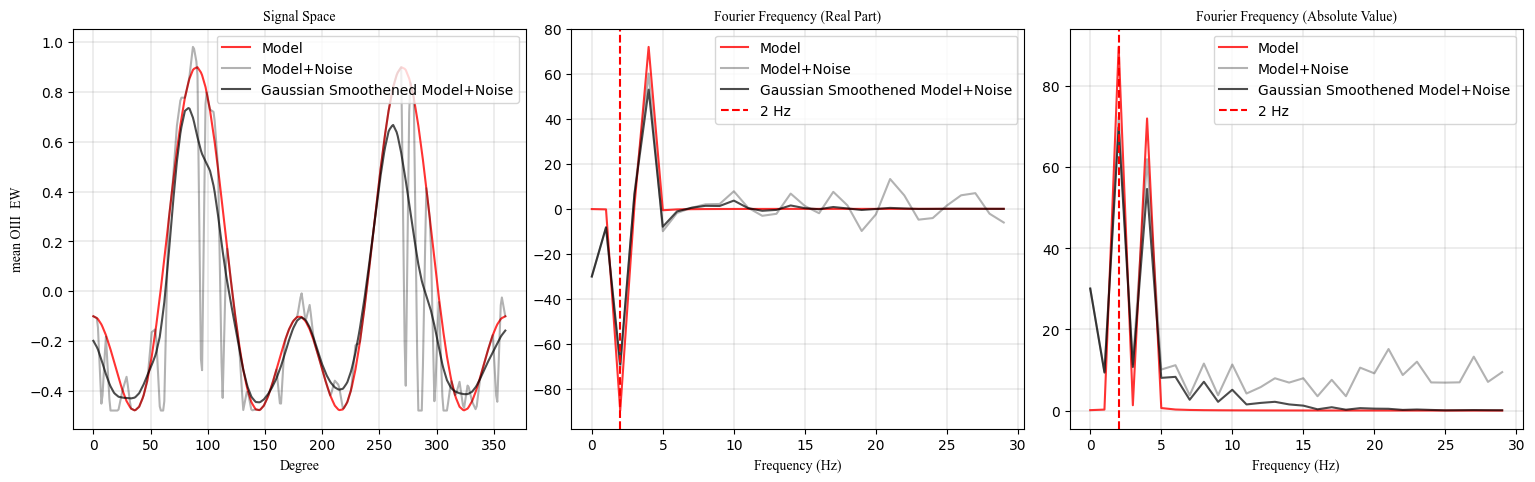

In [15]:
fig = plt.figure(figsize=(10, 7))

rows = 1
columns = 3


fig.add_subplot(rows, columns, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.title('Signal Space', fontproperties=font)
plt.xlabel('Degree', fontproperties=font)
plt.ylabel('mean OIII  EW' , fontproperties=font)
plt.plot(intp_o_n, c='r',alpha=0.8, label='Model')
plt.plot(intp_t_n, c='k',alpha=0.3,  label='Model+Noise')
plt.plot(intp_sm_n, c='k',alpha=0.7, label='Gaussian Smoothened Model+Noise')
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.legend(loc='upper right')


fig.add_subplot(rows, columns, 2)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.title('Fourier Frequency (Real Part)', fontproperties=font)
plt.xlabel('Frequency (Hz)', fontproperties=font)
plt.plot(fft(intp_o_n)[0:30], c='r',alpha=0.8, label='Model')
plt.plot(fft(intp_t_n)[0:30],c='k',alpha=0.3,  label='Model+Noise')
plt.plot(fft(intp_sm_n)[0:30], c='k',alpha=0.7, label='Gaussian Smoothened Model+Noise')
bound = [2]
for xc in bound:
    plt.axvline(x = xc, linestyle = '--', color = 'r',label = '2 Hz')
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.legend(loc='upper right')

fig.add_subplot(rows, columns, 3)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.title('Fourier Frequency (Absolute Value)', fontproperties=font)
plt.xlabel('Frequency (Hz)', fontproperties=font)
plt.plot(abs(fft(intp_o_n))[0:30], c='r',alpha=0.8, label='Model')
plt.plot(abs(fft(intp_t_n))[0:30],c='k',alpha=0.3,  label='Model+Noise')
plt.plot(abs(fft(intp_sm_n))[0:30], c='k',alpha=0.7, label='Gaussian Smoothened Model+Noise')
bound = [2]
for xc in bound:
    plt.axvline(x = xc, linestyle = '--', color = 'r',label = '2 Hz')
plt.legend(loc='upper right')
plt.grid(color='grey', linestyle='-', linewidth=0.2)


plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=3, 
                top=0.9, 
                wspace=0.1, 
                hspace=0.2)

plt.show()

In [16]:

for i in range(ew_value.shape[0]):
    for j in range(ew_value.shape[0]):
        sim_c = copy.deepcopy(sim_o)
        sim_t = randize(sim_c)
        # Intepolate to 100
        x = np.linspace(0,2*np.pi,100)
        x2 = np.linspace(0,2*np.pi,361)
        int_mid_t = scipy.interpolate.interp1d(x, sim_t, kind='linear')
        intp_t = int_mid_t(x2)
        
        for k in range(len(intp_t)):
            if np.isnan(ew_value[i][j]) == False:
                if round(phi[i][j]) == k:
                    ew_value[i][j] = 5*intp_t[k] + np.random.randint(0,10,1)/10
                else:
                    pass
            else:
                pass

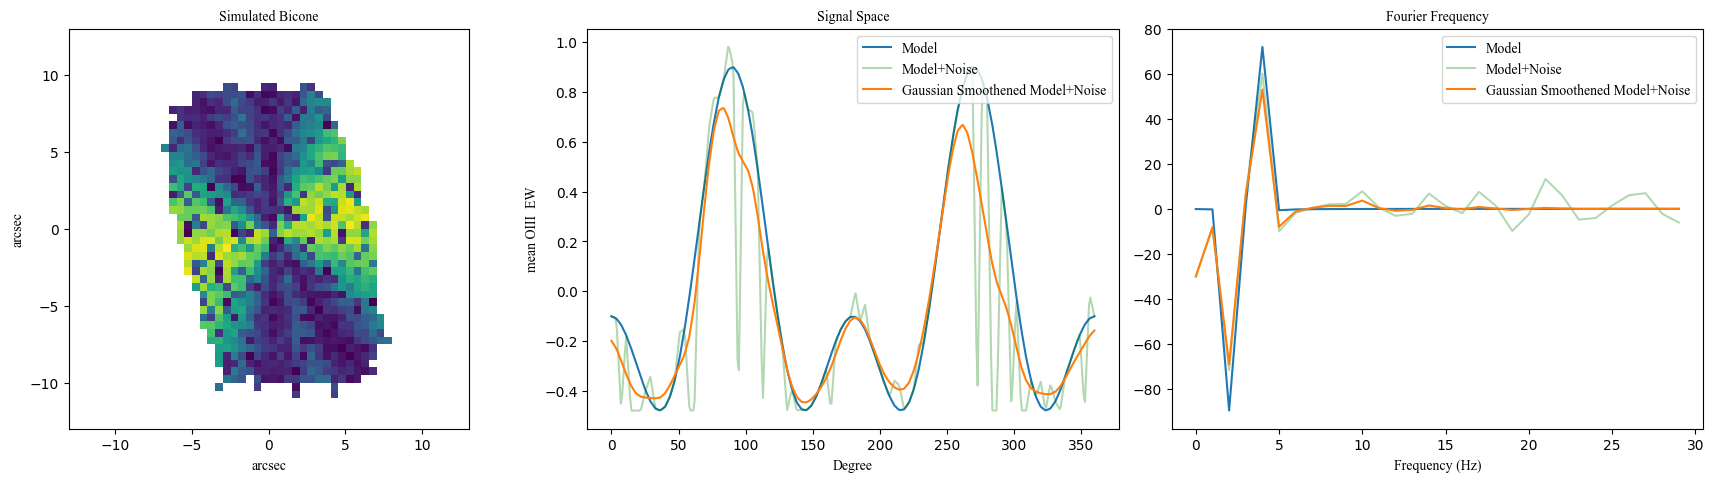

In [17]:

fig = plt.figure(figsize=(10, 7))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.title("Simulated Bicone", fontproperties=font)
plt.xlabel('arcsec',fontproperties=font)
plt.ylabel('arcsec',fontproperties=font)
plt.imshow(ew_value, cmap = 'viridis',extent=[-1*x_tik, x_tik, -1*y_tik, y_tik])


fig.add_subplot(rows, columns, 2)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.title('Signal Space',fontproperties=font)
plt.xlabel('Degree', fontproperties=font)
plt.ylabel('mean OIII  EW' , fontproperties=font)
plt.plot(intp_o_n, label='Model')
plt.plot(intp_t_n, c='g',alpha=0.3,  label='Model+Noise')
plt.plot(intp_sm_n, label='Gaussian Smoothened Model+Noise')
plt.legend(loc='upper right',prop=font)


fig.add_subplot(rows, columns, 3)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.title('Fourier Frequency',fontproperties=font)
plt.xlabel('Frequency (Hz)', fontproperties=font)
plt.plot(fft(intp_o_n)[0:30], label='Model')
plt.plot(fft(intp_t_n)[0:30],c='g',alpha=0.3,  label='Model+Noise')
plt.plot(fft(intp_sm_n)[0:30], label='Gaussian Smoothened Model+Noise')
plt.legend(loc='upper right',prop=font)





plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=3.5, 
                top=0.9, 
                wspace=0.1, 
                hspace=0.2)
plt.show()